In [53]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns

# Section 1 – Traditional Mean Variance Allocation #

### 1. Portfolio Summary Statistics ###
Mean, Standard Deviation (Volatility), Sharpe Ratio, Covariances

In [115]:
portfolio_df = pd.read_excel('portfolio.xlsx')
# print(portfolio_df.head(5))
returns_df = portfolio_df.drop(columns=['Date'])

summary_statistics_1 = pd.DataFrame()
summary_statistics_1['Mean'] = returns_df.std()
summary_statistics_1['Volatility'] = returns_df.mean()
summary_statistics_1['Sharpe Ratio'] = summary_statistics_1['Mean'] / summary_statistics_1['Volatility']

summary_statistics_1


,Mean,Volatility,Sharpe Ratio
AXP,0.070700,0.015719,4.497636
BAC,0.096545,0.015862,6.086353
BK,0.067668,0.009038,7.487008
CVX,0.067041,0.008938,7.500935
DVA,0.076253,0.012926,5.899326
KO,0.046055,0.009930,4.638220
MCO,0.077685,0.020985,3.701835
USB,0.060069,0.010886,5.518105
VRSN,0.068904,0.019799,3.480210
VZ,0.047143,0.008654,5.447395


           AXP       BAC        BK       CVX       DVA        KO       MCO  \
AXP   0.004998  0.003791  0.002464  0.002731  0.001804  0.001350  0.002503   
BAC   0.003791  0.009321  0.004784  0.002948  0.002532  0.000929  0.002708   
BK    0.002464  0.004784  0.004579  0.002604  0.001829  0.000935  0.002667   
CVX   0.002731  0.002948  0.002604  0.004494  0.001465  0.001189  0.001907   
DVA   0.001804  0.002532  0.001829  0.001465  0.005815  0.000893  0.001501   
KO    0.001350  0.000929  0.000935  0.001189  0.000893  0.002121  0.000742   
MCO   0.002503  0.002708  0.002667  0.001907  0.001501  0.000742  0.006035   
USB   0.002646  0.003654  0.002562  0.002158  0.001183  0.001015  0.001886   
VRSN  0.001697  0.001597  0.001493  0.001596  0.001212  0.001017  0.001638   
VZ    0.000603  0.000229  0.000389  0.001250  0.000811  0.001027  0.000638   

           USB      VRSN        VZ  
AXP   0.002646  0.001697  0.000603  
BAC   0.003654  0.001597  0.000229  
BK    0.002562  0.001493  0.00

<Axes: >

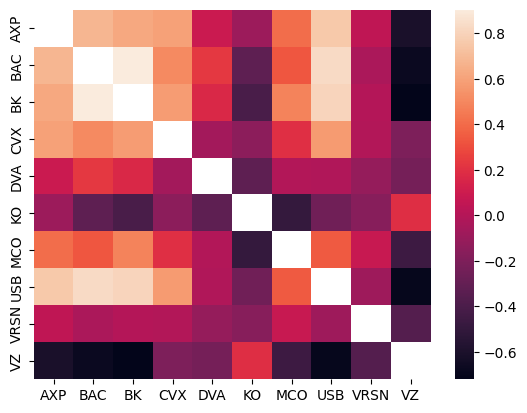

In [116]:
cov_matrix = returns_df.cov()
print(cov_matrix)

corr_matrix = cov_matrix.corr()
corr_matrix[corr_matrix == 1] = None
sns.heatmap(corr_matrix)


### 2. Mean-Variance Frontier ###
(a) Compute and display the tangency portfolio weights. (b) Compute the Mean, Volatility, and Sharpe for the tangency portfolio. Add it to the original Data Frame. (c) How does the mean return and Sharpe compare for the tangency vs other assets? 

         Weight
Stock          
AXP   -0.012494
BAC    0.126289
BK    -0.044938
CVX   -0.002082
DVA    0.132943
KO     0.133261
MCO    0.129052
USB    0.072361
VRSN   0.162911
VZ     0.302697


,Mean,Volatility,Sharpe Ratio
AXP,0.070700,0.015719,4.497636
BAC,0.096545,0.015862,6.086353
BK,0.067668,0.009038,7.487008
CVX,0.067041,0.008938,7.500935
DVA,0.076253,0.012926,5.899326
KO,0.046055,0.009930,4.638220
MCO,0.077685,0.020985,3.701835
USB,0.060069,0.010886,5.518105
VRSN,0.068904,0.019799,3.480210
VZ,0.047143,0.008654,5.447395


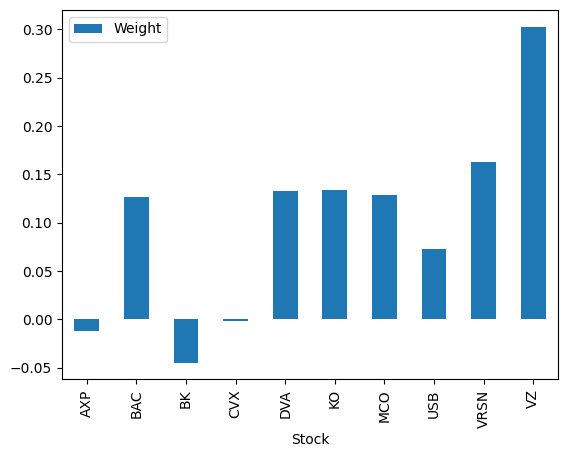

In [117]:
def tan_portfolio_weights(mean_rets, cov_matrix):
    inv_cov = np.linalg.inv(cov_matrix)
    ones = np.ones(mean_rets.shape)
    return (inv_cov @ mean_rets) / (ones.T @ inv_cov @ mean_rets)

tangency_portolio = pd.DataFrame()
tangency_portolio['Stock'] = list(returns_df.columns)
tangency_portolio = tangency_portolio.set_index('Stock')
tangency_portolio['Weight'] = tan_portfolio_weights(summary_statistics_1['Mean'], cov_matrix)
print(tangency_portolio)
tangency_portolio.plot.bar()

new_row = {
    'Mean': np.dot(tangency_portolio['Weight'], summary_statistics_1['Mean']),
    'Volatility':  np.sqrt(np.dot(tangency_portolio.T, np.dot(cov_matrix, tangency_portolio)))[0][0],
}
new_row['Sharpe Ratio'] = new_row['Mean'] / new_row['Volatility']

# summary_statistics_2['Mean'] = np.sum(tangency_portolio['Weight'] * summary_statistics_1['Mean'])
# tangency_portfolio_variance = np.dot(tangency_portolio.T, np.dot(cov_matrix, tangency_portolio))
# print(np.sqrt(np.dot(tangency_portolio.T, np.dot(cov_matrix, tangency_portolio)))[0][0])
# summary_statistics_2['Volatility'] = np.sqrt(np.dot(tangency_portolio.T, np.dot(cov_matrix, tangency_portolio)))[0][0]
# summary_statistics_2['Sharpe Ratio'] = summary_statistics_2['Mean'] / summary_statistics_2['Volatility']

summary_statistics_1.loc['Tangency'] = new_row
summary_statistics_1

Definitely did some miscalculation here because the tangency portfolio should have a significantly higher Sharpe Ratio.

### 3. Adjusting Allocation ###
(a) Compute and display the weights of MV portfolio with target mean return of .01. (b) Calculate Mean, Volatility, and Sharpe for the adjusted portfolio. Add it to stats Dataframe. How have they changed?

In [78]:
def gmv_portfolio(cov_matrix):
    try:
        cov_inv = np.linalg.inv(cov_matrix)
    except TypeError:
        cov_inv = np.linalg.inv(np.array(cov_matrix))

    one_vector = np.ones(len(cov_matrix.index))
    return cov_inv @ one_vector / (one_vector @ cov_inv @ (one_vector))

def mv_portfolio(mean_rets, cov_matrix, target=None):
    w_tan = tan_portfolio_weights(mean_rets, cov_matrix)

    if target is None:
        return w_tan

    w_gmv = gmv_portfolio(cov_matrix)
    delta = (target - mean_rets @ w_gmv) / (mean_rets @ w_tan - mean_rets @ w_gmv)
    return delta * w_tan + (1 - delta) * w_gmv
